In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot, imsave
from ponyslayer import unicorn, transform, chessboard_detection
from Kmean_BG_segment import segment

## Parameter Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.15 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

## Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (3, 3)

## Load Image

In [4]:
frame = cv2.imread("Real8.png")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
original = frame.copy()

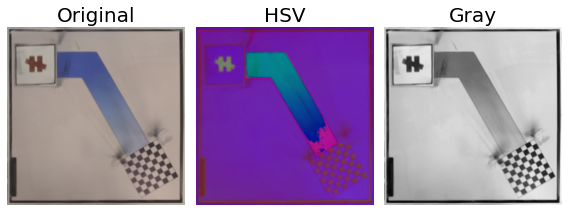

In [5]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, BlurKernelSize, 0)
HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
imshows([original, HSV, gray], ["Original", 'HSV', 'Gray'])
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.medianBlur(frame,5)
frame = cv2.bilateralFilter(frame,9,75,75)

## Find Destination

180
179
178
159
158
147
126
137
128
127
126
105
107
106
105
84
85
84
63
31
30
10
9
42
21


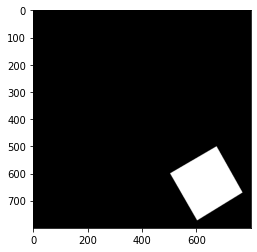

In [6]:
Marker_dst = unicorn.Marker(chessboard_detection.getChessContour(gray)[0])
imshow(immask(Marker_dst.contour, frame))

## Find Path(s)

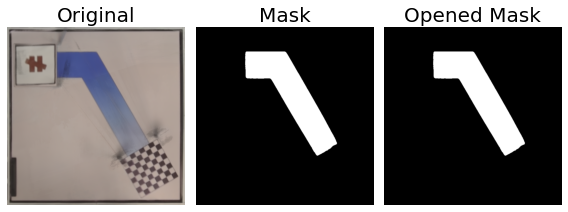

Path count: 1


In [7]:
path_mask = segment(frame, K=3)
kernel = np.ones(BlurKernelSize,np.uint8)
path_mask_opening = cv2.morphologyEx(path_mask, cv2.MORPH_OPEN, kernel)
imshows([original, path_mask, path_mask_opening], ["Original", "Mask", "Opened Mask"])
contours,hierarchy = cv2.findContours(path_mask_opening, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("Path count: " + str(len(contours)))

## Skeletonize Path(s)

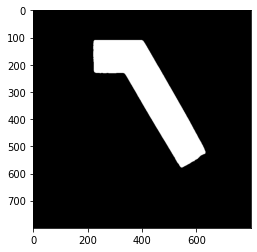

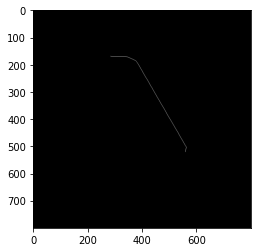

In [8]:
from skimage.morphology import skeletonize
from skimage import data
from skimage.util import invert
from scipy.ndimage import generic_filter

path_masks = [immask(cnt, frame) for cnt in contours]
path_skeletons = []
for i in range(len(path_masks)):
    imshow(path_masks[i])
    skeleton = skeletonize(path_masks[i], method='lee')
    path_skeletons.append(skeleton)
    imshow(skeleton)

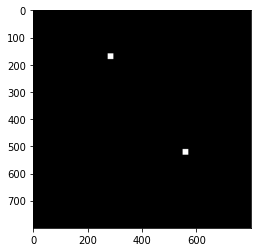

In [9]:
# Line ends filter
def lineEnds(P):
    """Central pixel and just one other must be set to be a line end"""
    return 255 * ((P[4]==255) and np.sum(P)==510)
end_points = []
path_cnts = []
path_cnts_approx = []
for skeleton in path_skeletons:
    point = []
    result = generic_filter(skeleton, lineEnds, (3, 3))
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            if result[y][x] == 255: point.append((x, y))
    imshow(cv2.dilate(result,kernel,iterations = 10))
    end_points.append(point)
    contours,_ = cv2.findContours(skeleton, cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    contours_approx,_ = cv2.findContours(skeleton, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    path_cnts.append(contours[0])
    path_cnts_approx.append(contours_approx[0])

## Generate 2D Waypoints and Extract Gradient

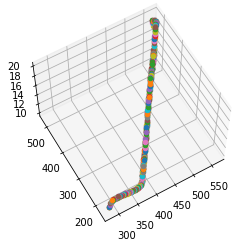

AttributeError: 'AxesSubplot' object has no attribute 'ravel'

In [12]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
visual = []

trajectories = []
for path_cnt in path_cnts:
    trajectory = []
    status = False
    for item in path_cnt:
        point = (item[0][0], item[0][1])
        if point in end_points[0]:
            if status == True: break
            status = True
        if status: trajectory.append(point)
    trajectories.append(trajectory)
    P = unicorn.Path(path_cnt)
    P.waypoints = trajectory
    waypoints3D = P.generate_trajectory3D(src=gray,
                                             min_height=min_height,
                                             max_height=max_height,
                                             gradient_crop_ratio=gradient_crop_ratio,
                                             min_intensity_range=min_intensity_range)
    for waypoint in waypoints3D: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
    canvas = original.copy()
    for i in range(len(trajectory)): cv2.circle(canvas, trajectory[i], 5, (0, 255, 0), -1)
    visual.append(canvas)
ax.view_init(azim=-120, elev=60)
plt.show()
imshows(visual, [str(i) for i in range(len(visual))])